In [1]:
import sys
import os
from itertools import product
import math
import numpy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE, MDS
#import umap
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

sys.path.append(os.path.abspath("../"))
from distance_functions import *

In [2]:
def symmetrize(A):
    n = A.shape[0]
    B = A.copy()
    B[np.tril_indices(n)] = B.T[np.tril_indices(n)]
    return B

In [3]:
n = 10000

In [4]:
depths = np.array([1, 2, 3, 4, 5])
widths = np.array([200, 400, 600, 800, 1000])
trials = np.array([0, 1, 2, 3, 4])

num_depths = len(depths)
num_widths = len(widths)
num_trials = len(trials)

total_models = len(depths) * len(widths) * len(trials)

model_names = []
for depth in depths:
    for width in widths:
        for trial in trials:
            model_names.append(f'fc_cifar_{depth}_{width}_{trial}')
model_names = np.array(model_names)

In [5]:
distnames = np.array(['lin_cka_dist',
             'lin_cka_prime_dist',
             'mean_cca_e2e',
             'mean_sq_cca_e2e',
             'procrustes',
             'pwcca_dist_e2e',
             'predictor_dist_0.0',
             'predictor_dist_1e-20',
             'predictor_dist_1e-19',
             'predictor_dist_1e-18',
             'predictor_dist_1e-17',
             'predictor_dist_1e-16',
             'predictor_dist_1e-15',
             'predictor_dist_1e-14',
             'predictor_dist_1e-13',
             'predictor_dist_1e-12',
             'predictor_dist_1e-11',
             'predictor_dist_1e-10',
             'predictor_dist_1e-09',
             'predictor_dist_1e-08',
             'predictor_dist_1e-07',
             'predictor_dist_1e-06',
             'predictor_dist_1e-05',
             'predictor_dist_0.0001',
             'predictor_dist_0.001',
             'predictor_dist_0.01',
             'predictor_dist_0.1',
             'predictor_dist_1.0',
             'predictor_dist_10.0',
             'predictor_dist_100.0',
             'predictor_dist_1000.0',
             'predictor_dist_10000.0'])

In [6]:
stats = np.load(f"distances/{n}/stats.npz")
dist_pairs_saved = stats["dist_pairs_saved"]

In [7]:
print(np.arange(total_models) - np.sum(dist_pairs_saved, axis=0))
print(np.arange(total_models) - np.flip(np.sum(dist_pairs_saved, axis=1)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## Pretrained network embeddings plots

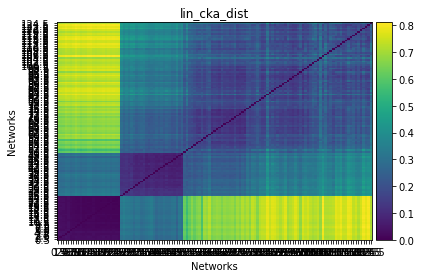

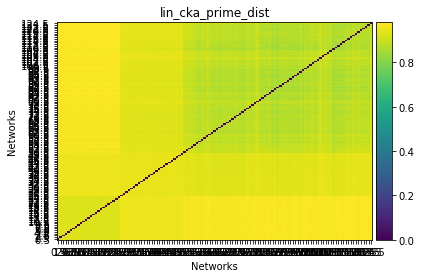

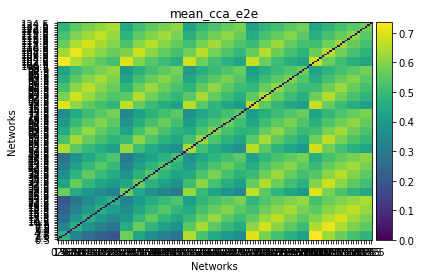

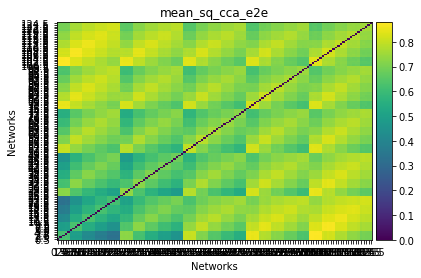

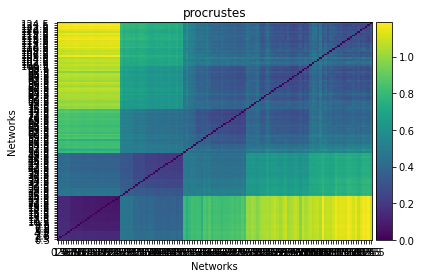

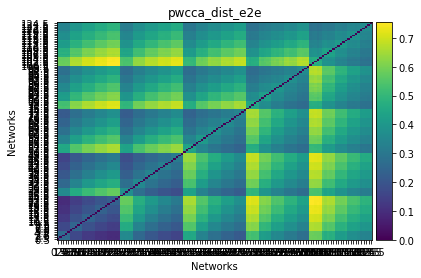

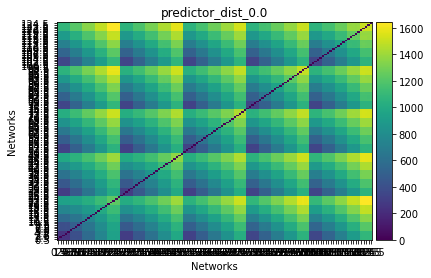

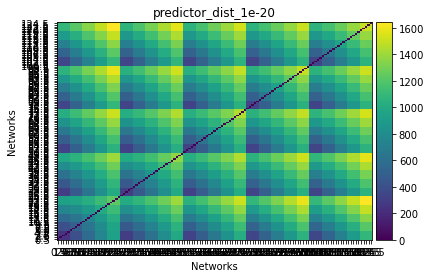

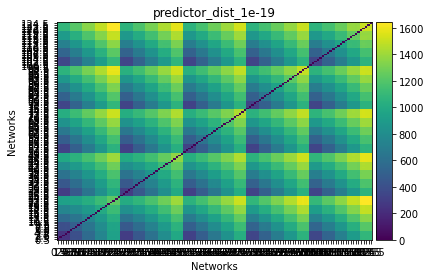

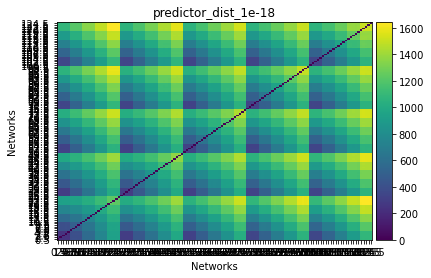

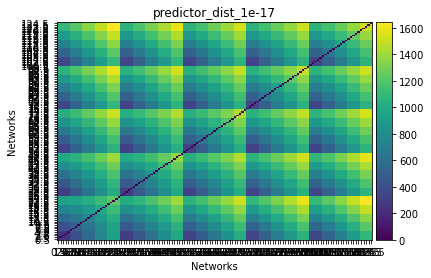

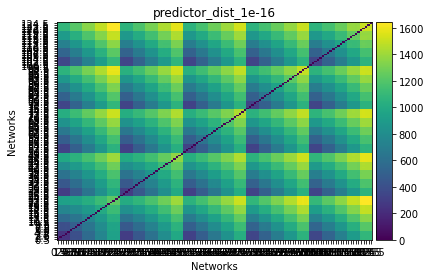

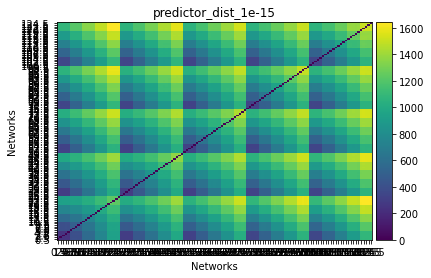

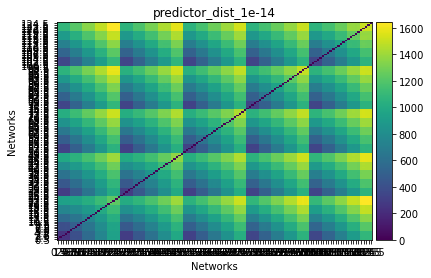

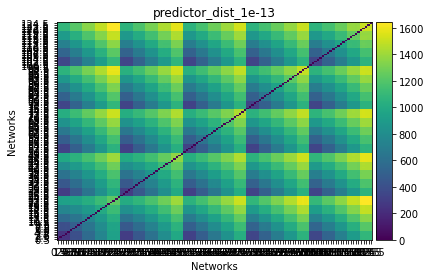

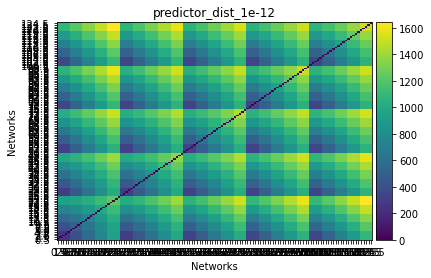

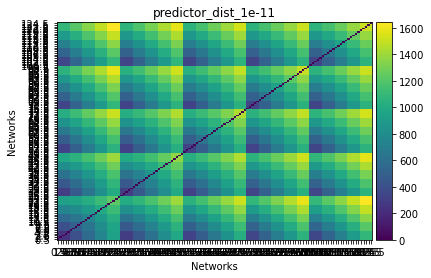

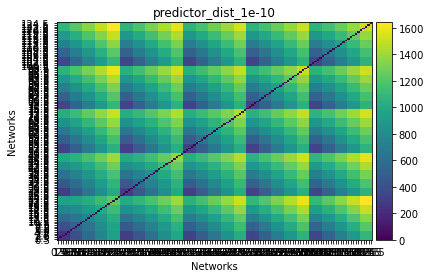

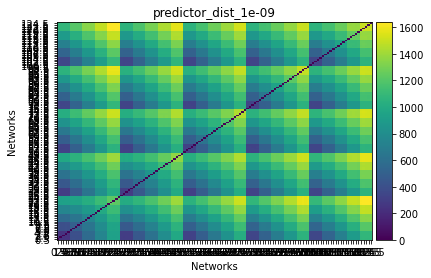

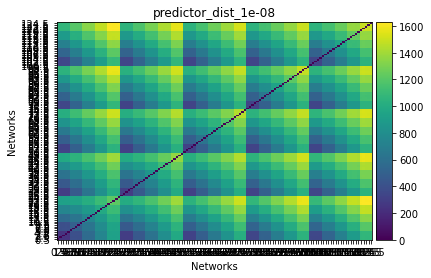

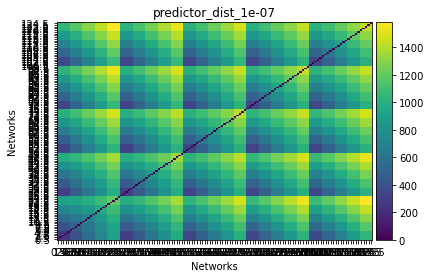

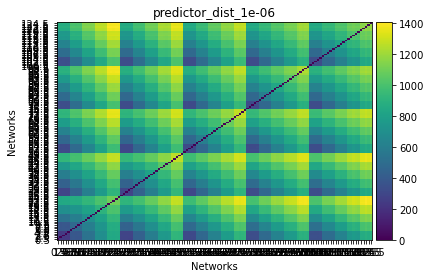

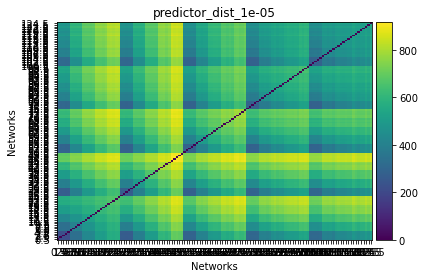

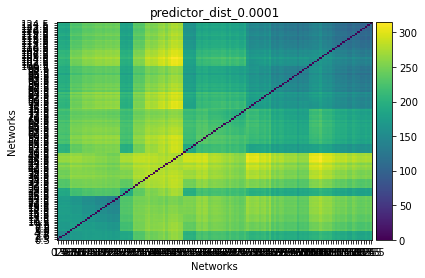

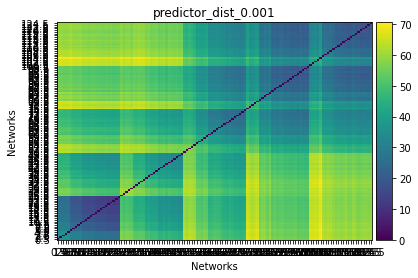

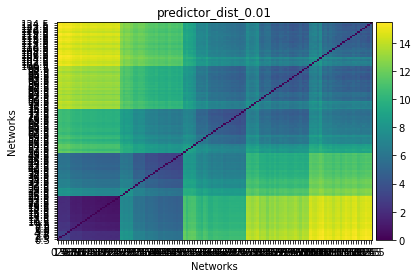

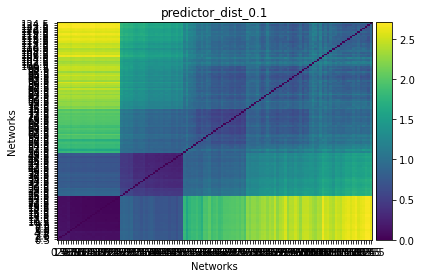

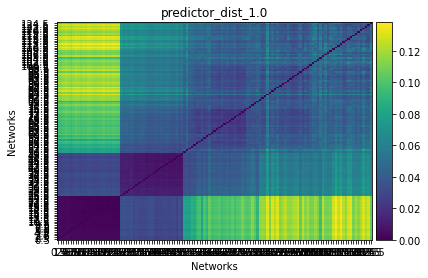

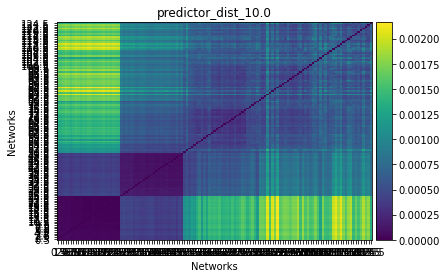

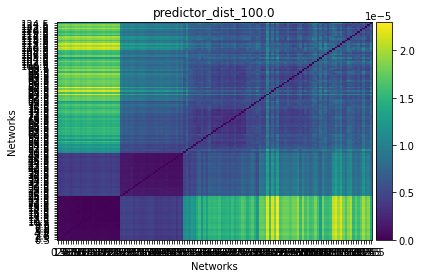

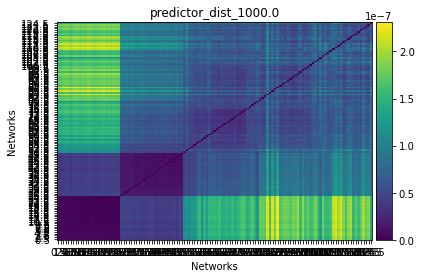

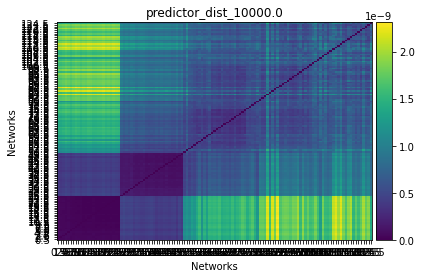

In [8]:
stats = np.load(f"distances/{n}/stats.npz")
stats_model_names = stats["model_names"]
assert np.all(stats_model_names == model_names)

for distname in distnames:
    D = np.load(f'distances/{n}/{distname}.npy')
    D = np.reshape(D, [total_models, total_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    
    fig, ax = plt.subplots()
    im = ax.pcolormesh(D)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title(distname)
    ax.set_yticks(np.arange(total_models) + 0.5)
    ax.set_ylabel("Networks")
    ax.set_xticks(np.arange(total_models) + 0.5)
    ax.set_xlabel("Networks")
    plt.show()

In [9]:
model_depths = depths[np.arange(total_models) // (num_widths * num_trials)]
model_widths = widths[(np.arange(total_models) // num_trials) % num_widths]

In [10]:
num_dists = len(distnames)
D_aves = np.zeros((num_widths*num_depths, num_widths*num_depths, num_dists))
for k in range(num_dists):
    D = np.load(f'distances/{n}/{distnames[k]}.npy')
    D = np.reshape(D, [total_models, total_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    
    D_ave = np.zeros((num_widths*num_depths, num_widths*num_depths))
    for i in range(num_trials):
        for j in range(num_trials):
            if i != j:
                Dij = D[i::num_trials, j::num_trials]
                D_ave += Dij
    D_ave = D_ave / num_trials*(num_trials-1)
    D_aves[:, :, k] = D_ave

In [11]:
embed_type = "MDS"

num_dists = len(distnames)

embeddings = np.zeros((num_dists, total_models, 2))
for i in range(num_dists):
    print(f"Computed {distnames[i]}")
    D = np.load(f'distances/{n}/{distnames[i]}.npy')
    D = np.reshape(D, [total_models, total_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    
    if np.any(D < 0):
        embeddings[i, :, :] = np.nan
        print("isnan")
        continue

    if embed_type == "TSNE":
        X_embedded = TSNE(n_components=2, perplexity=20.0, init="random", metric="precomputed").fit_transform(D)
    elif embed_type == "UMAP":
        X_embedded = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1).fit_transform(np.sqrt(D))
    elif embed_type == "MDS":
        X_embedded = MDS(n_components=2, dissimilarity="precomputed").fit_transform(np.sqrt(D))

    embeddings[i, :, :] = X_embedded

Computed lin_cka_dist
Computed lin_cka_prime_dist
Computed mean_cca_e2e
Computed mean_sq_cca_e2e
Computed procrustes
Computed pwcca_dist_e2e
Computed predictor_dist_0.0
Computed predictor_dist_1e-20
Computed predictor_dist_1e-19
Computed predictor_dist_1e-18
Computed predictor_dist_1e-17
Computed predictor_dist_1e-16
Computed predictor_dist_1e-15
Computed predictor_dist_1e-14
Computed predictor_dist_1e-13
Computed predictor_dist_1e-12
Computed predictor_dist_1e-11
Computed predictor_dist_1e-10
Computed predictor_dist_1e-09
Computed predictor_dist_1e-08
Computed predictor_dist_1e-07
Computed predictor_dist_1e-06
Computed predictor_dist_1e-05
Computed predictor_dist_0.0001
Computed predictor_dist_0.001
Computed predictor_dist_0.01
Computed predictor_dist_0.1
Computed predictor_dist_1.0
Computed predictor_dist_10.0
Computed predictor_dist_100.0
Computed predictor_dist_1000.0
Computed predictor_dist_10000.0


PermissionError: [Errno 13] Permission denied: '../paper_figures/cifar_width_depth.pdf'

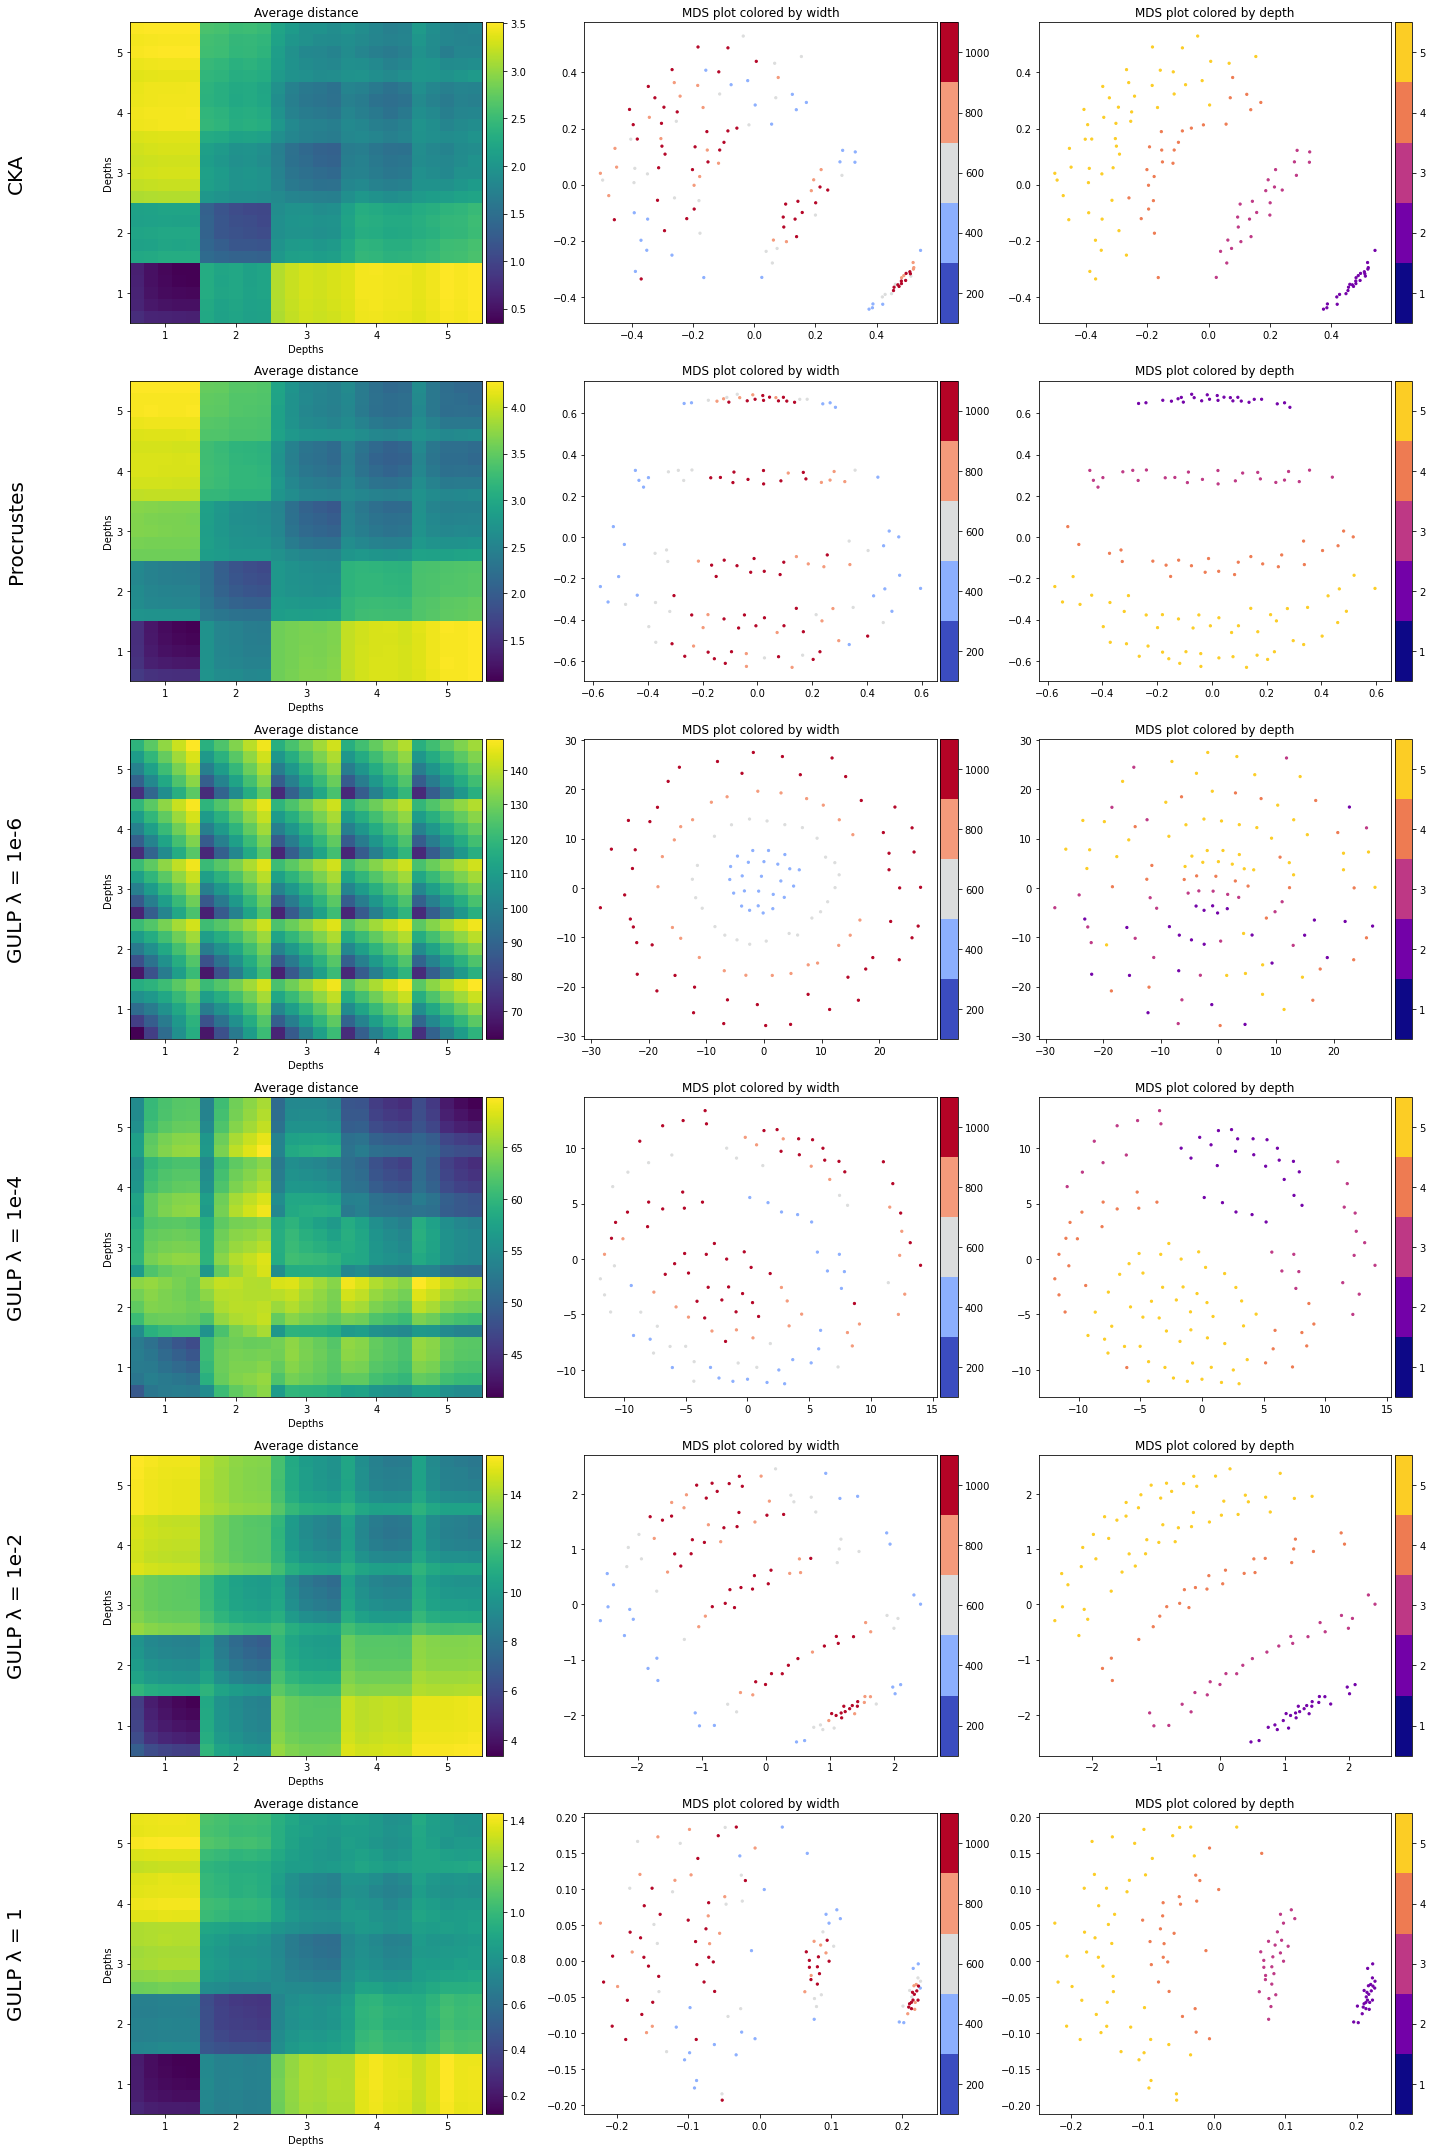

In [12]:
dist_inds = [0, 4, 21, 23, 25, 27]

labels = ['CKA', 'Procrustes', 'GULP λ = 1e-6', 'GULP λ = 1e-4', 'GULP λ = 1e-2', 'GULP λ = 1']
#labels = distnames[dist_inds]

cmap_width = cm.get_cmap("coolwarm")
cmaplist_width = [cmap_width(i) for i in range(cmap_width.N)]
cmap_width = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist_width, cmap_width.N)
norm_width = mpl.colors.BoundaryNorm(np.arange(len(widths)+1), cmap_width.N)

cmap_depth = cm.get_cmap("plasma")
cmaplist_depth = [cmap_depth(i) for i in range(int(0.9*cmap_depth.N))]
cmap_depth = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist_depth, cmap_depth.N)
norm_depth = mpl.colors.BoundaryNorm(np.arange(len(depths)+1), cmap_depth.N)

fig, axs = plt.subplots(len(dist_inds), 4, figsize=(20, 30), gridspec_kw={'width_ratios': [1, 20, 20, 20]})
for i in range(len(dist_inds)):
    ax = axs[i, 0]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_ylabel(labels[i], fontsize=20)
    
    ax = axs[i, 1]
    im = ax.pcolormesh(np.sqrt(D_aves[:, :, dist_inds[i]]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title(f"Average distance")
    ax.set_yticks(np.linspace(num_widths/2, num_widths*(num_depths-1/2), num_depths))
    ax.set_yticklabels(depths)
    ax.set_ylabel("Depths")
    ax.set_xticks(np.linspace(num_widths/2, num_widths*(num_depths-1/2), num_depths))
    ax.set_xticklabels(depths)
    ax.set_xlabel("Depths")
    
    X_embedded = embeddings[dist_inds[i], :, :]

    ax = axs[i, 2]
    sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=model_widths/200, s=5, cmap=cmap_width, norm=norm_width)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(sc, cax=cax, orientation='vertical', ticks=mpl.ticker.FixedLocator(np.arange(num_widths)+0.5))
    cbar.ax.set_yticklabels(widths)
    ax.set_title(f'{embed_type} plot colored by width')
    
    ax = axs[i, 3]
    sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=model_depths, s=5, cmap=cmap_depth, norm=norm_depth)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(sc, cax=cax, orientation='vertical', ticks=mpl.ticker.FixedLocator(np.arange(num_depths)+0.5))
    cbar.ax.set_yticklabels(depths)
    ax.set_title(f'{embed_type} plot colored by depth')
fig.tight_layout()
plt.savefig("../paper_figures/cifar_width_depth.pdf")
plt.show()